In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipfile
import _pickle
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
import time
import os

from ourfunctions_v3 import clean_nan_samples, try_clf, apply_feature_selection

In [4]:
m = 2000; M = 12000; 
bin_size = 5
step_size = 1; # interpolation step size

# path = "D:/GitHub/Machine-Learning/Kaggle/"
path = 'C:/Users/Javi/Documents/GitHub/Machine-Learning/Kaggle/'

In [5]:
savepath = path + 'Kaggle classifiers/bin size 5/'
path_results = path + 'Kaggle_results/'

ncpu = os.cpu_count()
if (ncpu>2): njobs = ncpu - 2; 
else: njobs = 1;

In [6]:
zf = zipfile.ZipFile(path+'zipped_TrainData.zip', 'r')
df_train = _pickle.loads(zf.open('TrainData.pkl').read())
zf.close()

zf = zipfile.ZipFile(path+'zipped_TestDataUnlabeled.zip', 'r')
df_test = _pickle.loads(zf.open('TestDataUnlabeled.pkl').read())
zf.close()

In [7]:
def remove_noise(df):
    N = len(df)  # number of samples
    idx_list = []
    for idx in range(N): 
        intensity = df[['intensity']].iloc[idx].values[0]
        mzcoord   = df[['coord_mz']].iloc[idx].values[0]

        if np.var(intensity) < 100:
          idx_list.append(idx)
          print('Training sample', idx, ' eliminated')
    new_df = df.drop(index = idx_list)
    return new_df

In [8]:
df_train = remove_noise(df_train)

Training sample 339  eliminated
Training sample 490  eliminated


In [9]:
def interpolate_spectra(df, m, M, step_size):
    # step_size is the size of each step; 1 interpolates very well.
    mz_range = np.arange(m,M+1,step_size)
    
    N = len(df)  # number of samples
    L = len(mz_range)  # length of new spectrum (number of bins)
    all_data = np.zeros((N,L))
    idx_list = []
    
    for idx in range(N): 
        intensity = df[['intensity']].iloc[idx].values[0]       
        mzcoord   = df[['coord_mz']].iloc[idx].values[0]
        interpolated_spectrum = np.interp(x=mz_range,xp=mzcoord,fp=intensity)
        interpolated_spectrum = interpolated_spectrum / np.max(interpolated_spectrum)
        plt.plot(interpolated_spectrum)
        all_data[idx,:] = interpolated_spectrum
    new_df = pd.DataFrame(data=all_data, columns = mz_range, index = df.index)
    plt.show()
    return new_df

Training samples: 359 and test_train samples: 155


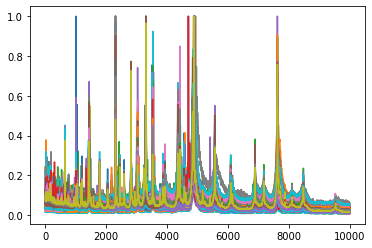

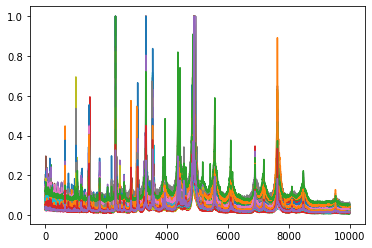

Spectrum interpolated!


In [10]:
# df_train = df_train.drop_duplicates(subset='ID_sample') # eliminate duplicates
# Let's work without duplicates from now on, to avoid having same sample in training and test_training sets

# Extract data (spectra) and targets of the df_train set
data = df_train.iloc[:,-2:]
targets = df_train.iloc[:,1:-2]

# Then, split into a train and test_train set
data_train, data_test_train, targets_train, targets_test_train = train_test_split(data, targets, test_size=0.3, random_state=0) # split the data
print('Training samples: '+str(len(data_train))+' and test_train samples: ' + str(len(data_test_train)) )

# apply the bins to all spectra, so that our feature space becomes the same for all samples (make them regular, all the same)
spectrum_train = interpolate_spectra(data_train,m,M,step_size)
spectrum_test_train = interpolate_spectra(data_test_train,m,M,step_size)
print('Spectrum interpolated!')
# these spectrum_... are our X for training

# PLS Regression
It is clear that Im not able to make PLSCanonical to work.

Nevertheless, on the web I have found that PLS Regression can be used with binary data:
https://www.mfitzp.com/article/partial-least-squares-discriminant-analysis-plsda/
https://stackoverflow.com/questions/18390150/pls-da-algorithm-in-python
It is called PLS Discriminant Analysis, but basically Y is the binary vector. So let's try that:

In [ ]:
from sklearn.cross_decomposition import PLSRegression
categories = targets_train.columns[:]  
c = 0
cat = categories[c]
X_train, Y_train = clean_nan_samples(spectrum_train,targets_train, c, cat)
X = X_train.to_numpy()
Y = Y_train.reshape(-1,1)
scores = []
for i in np.arange(1,100):
    p = PLSRegression(n_components=i)
    p.fit(X_train,Y_train)
    scores.append(p.score(X_train,Y_train))
    
plt.plot(scores)

In [ ]:
X_test_train, Y_test_train = clean_nan_samples(spectrum_test_train,targets_test_train, c, cat)
new = p.predict(X_test_train)

In [ ]:
print(X_test_train.shape)
print(new.shape)

In [ ]:
plt.plot(new)

In [ ]:
import copy
new2 = copy.copy(new)
new2[new2<0] = 0
new2[new2>1] = 1
plt.plot(new2)

In [ ]:
Y_test_train = Y_test_train.reshape(-1,1)
print(new2.shape)
print(Y_test_train.shape)

In [ ]:
roc_auc_score(Y_test_train,new2)

It seems to work pretty well! Later, I will pipeline the process in order to generate predictions. First, let's try with a more complicated antibiotic (4, CLINDAMICINA) in order to check how many components we need for a good reconstruction for that.

CLINDAMICINA


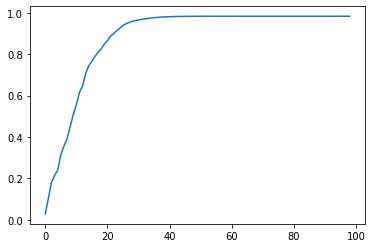

In [43]:
categories = targets_train.columns[:]  
c = 4
cat = categories[c]
print(cat)
X_train, Y_train = clean_nan_samples(spectrum_train,targets_train, c, cat)

scores = []
for i in np.arange(1,100):
    p = PLSRegression(n_components=i)
    p.fit(X_train,Y_train)
    scores.append(p.score(X_train,Y_train))
    
plt.plot(scores)

In [45]:
scores[40]

0.9810221257622949

In [46]:
new = p.predict(X_test_train) # with 100 components
roc_auc_score(Y_test_train,new)

0.5202913631633715

In [57]:
p2 = PLSRegression(n_components=25)
p2.fit(X_train, Y_train)
new2 = p2.predict(X_test_train)
roc_auc_score(Y_test_train,new2)

0.5480402358654181

In terms of test AUC, more doesnt always means better with n_components.

With around 40 new components, it is already able to keep all information (almost perfect prediction of Y_train). Nevertheless, this is highlightning that I dont really know how this is working. There is nothing such as the "variance accounted for" from PCA. Therefore, most likely, the value of n_components will have to be cross-validated.

Nevertheless, we are not using PLS for classification, but for extracting a new set of features over which to perform classification later. Therefore, should we cross-validate or just use an arbitrary number? For the moment being, I will use n_components = 30 and just forget about cross-validating it for the moment being.

## PLS feature selection into try_clf_pls
The idea of the pipeline is
* 1. Interpolation (to have a constant MZ axis)
* 2. Split in train and test_train (if applicable)
* 3. Over train data, obtain the PLS fit for each category, and apply it to both train and test data.
* 4. Train the desired classifier with the new features, and obtain the validation, train and test AUCs.

In the future, we can implement additional steps before 3:
* Peak selection, setting to zero everything that is not a peak
* Gaussian Mixture Models to select relevant peak areas and get values there for each spectra, as an additional / alternative feature selection method.

In [62]:
def pls_feature_fitting(spectrum_train, targets_train, n_comp=50):
    pls_list = []
    categories = targets_train.columns[:] 
    for c,cat in enumerate(categories):
        X_train, Y_train = clean_nan_samples(spectrum_train,targets_train, c, cat)
        p = PLSRegression(n_components=n_comp)
        p.fit(X_train, Y_train)
        pls_list.append(p)
    return pls_list        
        
def try_clf_pls(clf,params,n_cv=5,PLS_FEATURE_SELECTION=False, pls_list=None):  # new version! (after Sevilla)
    # Incorporates PLS feature selection and transformations
    n_comp = 50 # fixed for the moment being
    
    t1 = time.time()
    
    best_classifiers = [];
    grid_list = [];
    AUC_train = []; AUC_valid = [];
    
    categories = targets_train.columns[:]    
    for c,cat in enumerate(categories):

        print([cat]) # indicate in which antibiotic we are
        
        # Selection of train and test data (depending on whether there are NaN target values)
        X_train, Y_train = clean_nan_samples(spectrum_train,targets_train, c, cat)
        
        if PLS_FEATURE_SELECTION: # a boolean that decides whether to apply L1 feature selection (L1 feature list has to be already defined, and input to the function)
            X_train = pls_list[c].transform(X_train)
            
        # perform a GridSearchCV in order to train a classifier for this antibiotic
        grid = GridSearchCV(clf,param_grid=params,scoring='roc_auc',n_jobs=njobs,pre_dispatch='2*n_jobs', cv=n_cv,return_train_score=True)
        grid.fit(X_train, Y_train)

        # print the best parameters (to detect edge values), and save that classifier
        print('The best parameters are: ',grid.best_params_)
        best_clf = grid.best_estimator_
        best_classifiers.append(best_clf)
        grid_list.append(grid)
        
        best_clf = np.where(grid.cv_results_['rank_test_score']==1)[0][0]
        AUC_train.append(grid.cv_results_['mean_train_score'][best_clf])
        AUC_valid.append(grid.cv_results_['mean_test_score'][best_clf])
        
        print('Train AUC: ',np.round(AUC_train[-1],4),' and validation AUC: ',np.round(AUC_valid[-1],4))
        
    avg_AUC_train = np.mean(AUC_train)
    avg_AUC_valid = np.mean(AUC_valid)
    print('\n\nThe average train AUC is',np.round(avg_AUC_train,4),'and the avg validation AUC is',np.round(avg_AUC_valid,4))
    
    t2 = time.time()
    print('\nFull execution took ',np.round(t2-t1,1),'seconds')
    print('\nDONE!')
    return best_classifiers, grid_list, AUC_train, AUC_valid

In [73]:
pls_list = pls_feature_fitting(spectrum_train, targets_train, n_comp=10)

In [74]:
from sklearn.svm import SVC
clf = SVC(kernel='rbf', class_weight='balanced')

C_vector = 10. ** np.arange(-1,6)
gamma_vector = 10. ** np.arange(-10,1)
params = {'C':C_vector, 'gamma':gamma_vector}

rbf_SVM_best_clfs, grid_list, rbf_SVM_AUC_train, rbf_SVM_AUC_test_train = try_clf_pls(clf,params,5, True, pls_list)

['OXACILINA']
The best parameters are:  {'C': 10000.0, 'gamma': 1e-07}
Train AUC:  0.9536  and validation AUC:  0.9476
['AMIKACINA']
The best parameters are:  {'C': 100000.0, 'gamma': 1e-08}
Train AUC:  0.9629  and validation AUC:  0.9563
['AMOXI/CLAV']
The best parameters are:  {'C': 100000.0, 'gamma': 1e-08}
Train AUC:  0.9518  and validation AUC:  0.9445
['CIPROFLOXACINO']
The best parameters are:  {'C': 10000.0, 'gamma': 1e-06}
Train AUC:  0.9613  and validation AUC:  0.9479
['CLINDAMICINA']
The best parameters are:  {'C': 10000.0, 'gamma': 1e-06}
Train AUC:  0.967  and validation AUC:  0.9539
['ERITROMICINA']
The best parameters are:  {'C': 1000.0, 'gamma': 1e-06}
Train AUC:  0.9345  and validation AUC:  0.9296
['LEVOFLOXACINO']
The best parameters are:  {'C': 100.0, 'gamma': 1e-05}
Train AUC:  0.9713  and validation AUC:  0.9547
['PENICILINA']
The best parameters are:  {'C': 100000.0, 'gamma': 1e-07}
Train AUC:  0.9729  and validation AUC:  0.9468
['TOBRAMICINA']
The best paramet

In [75]:
def auc_over_test_with_pls(clf_list, pls_list, spectrum_test, targets_test):
    AUC_test = []
    categories = targets_test.columns[:]    
    for c,cat in enumerate(categories):
        print([cat])
        X_test, Y_test = clean_nan_samples(spectrum_test,targets_test, c, cat)
        X_test = pls_list[c].transform(X_test)
        Y_pred = clf_list[c].predict(X_test)
        AUC_test.append(roc_auc_score(Y_test,Y_pred))
        print('Test AUC:',AUC_test[-1])
    return AUC_test

In [76]:
AUC_test = auc_over_test_with_pls(rbf_SVM_best_clfs, pls_list, spectrum_test_train, targets_test_train)

['OXACILINA']
Test AUC: 0.760752688172043
['AMIKACINA']
Test AUC: 0.7627877237851663
['AMOXI/CLAV']
Test AUC: 0.7768817204301075
['CIPROFLOXACINO']
Test AUC: 0.8171052631578947
['CLINDAMICINA']
Test AUC: 0.5241935483870969
['ERITROMICINA']
Test AUC: 0.6099704032556418
['LEVOFLOXACINO']
Test AUC: 0.7945035460992909
['PENICILINA']
Test AUC: 0.6726190476190477
['TOBRAMICINA']
Test AUC: 0.7633738601823709


In [77]:
np.mean(AUC_test)

0.7202430890098511

In [72]:
# let's inspect the grid search
g = grid_list[0]
print(g.cv_results_['mean_test_score'])

[0.66136789 0.66136789 0.66136789 0.66136789 0.66472575 0.68303344
 0.75085953 0.84568227 0.81437458 0.66435786 0.54679599 0.66136789
 0.66136789 0.66136789 0.66136789 0.67191639 0.84713378 0.9827592
 0.97774916 0.81513712 0.68353846 0.54679599 0.66136789 0.66136789
 0.66136789 0.67223746 0.87366221 0.99807023 0.99974916 0.98700669
 0.81329766 0.68353846 0.54679599 0.66136789 0.66136789 0.67240468
 0.87603679 0.99924749 0.99991639 0.99974916 0.98700669 0.81329766
 0.68353846 0.54679599 0.66136789 0.67240468 0.8753612  0.99908027
 0.99991639 0.99991639 0.99974916 0.98700669 0.81329766 0.68353846
 0.54679599 0.67240468 0.87552843 0.99908027 0.99991639 0.99991639
 0.99991639 0.99974916 0.98700669 0.81329766 0.68353846 0.54679599
 0.87385619 0.99941472 0.99991639 0.99991639 0.99991639 0.99991639
 0.99974916 0.98700669 0.81329766 0.68353846 0.54679599]


Although not for all values the PLS is making it overfit, there is a clear problem: we are using all training data for PLS feature fitting (which involves the targets Y_train) and then performing cross-validation, using as validation set already used data. Therefore, I will now try to implement a pipeline to better cross-validate the classifiers:

In [89]:
from sklearn.pipeline import Pipeline


def pls_feature_fitting(spectrum_train, targets_train, n_comp=50):
    pls_list = []
    categories = targets_train.columns[:] 
    for c,cat in enumerate(categories):
        X_train, Y_train = clean_nan_samples(spectrum_train,targets_train, c, cat)
        p = PLSRegression(n_components=n_comp)
        p.fit(X_train, Y_train)
        pls_list.append(p)
    return pls_list        
        
def try_clf_pls_pipeline(clf,params,n_cv=5): 
    # Incorporates PLS feature selection and transformations
   
    t1 = time.time()
    
    best_classifiers = [];
    grid_list = [];
    AUC_train = []; AUC_valid = [];
    
    categories = targets_train.columns[:]    
    for c,cat in enumerate(categories):

        print([cat]) # indicate in which antibiotic we are
        
        # Selection of train and test data (depending on whether there are NaN target values)
        X_train, Y_train = clean_nan_samples(spectrum_train,targets_train, c, cat)
        
        pls = PLSRegression()
        pip = Pipeline(steps=[('pls',pls),('clf',clf)])
        
        # perform a GridSearchCV in order to train a classifier for this antibiotic
        grid = GridSearchCV(pip,param_grid=params,scoring='roc_auc',n_jobs=njobs,pre_dispatch='2*n_jobs', cv=n_cv,return_train_score=True)
        grid.fit(X_train, Y_train)

#         # print the best parameters (to detect edge values), and save that classifier
#         print('The best parameters are: ',grid.best_params_)
#         best_clf = grid.best_estimator_
#         best_classifiers.append(best_clf)
#         grid_list.append(grid)
        
#         best_clf = np.where(grid.cv_results_['rank_test_score']==1)[0][0]
#         AUC_train.append(grid.cv_results_['mean_train_score'][best_clf])
#         AUC_valid.append(grid.cv_results_['mean_test_score'][best_clf])
        
#         print('Train AUC: ',np.round(AUC_train[-1],4),' and validation AUC: ',np.round(AUC_valid[-1],4))
        
#     avg_AUC_train = np.mean(AUC_train)
#     avg_AUC_valid = np.mean(AUC_valid)
#     print('\n\nThe average train AUC is',np.round(avg_AUC_train,4),'and the avg validation AUC is',np.round(avg_AUC_valid,4))
    
    t2 = time.time()
    print('\nFull execution took ',np.round(t2-t1,1),'seconds')
    print('\nDONE!')
    return best_classifiers, grid_list, AUC_train, AUC_valid

In [90]:
clf = SVC(kernel='linear', class_weight='balanced')

C_vector = 10. ** np.arange(-1,6)
n_comp_vector = np.arange(14,60,15)
params = {'pls__n_components':n_comp_vector,'clf__C':C_vector}
linear_SVM_best_clfs, grid_list, linear_SVM_AUC_train, linear_SVM_AUC_valid = try_clf_pls_pipeline(clf,params)

['OXACILINA']


ValueError: could not broadcast input array from shape (359,14) into shape (359)

# TODO: manual cross-validation of PLS + clf